<a href="https://www.kaggle.com/code/sjain600/lightbm-model-with-feature-importances?scriptVersionId=233575554" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

## Data Understanding

In [3]:
train.shape

(1200000, 21)

In [4]:
test.shape

(800000, 20)

In [5]:
train.sample(10)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
395529,395529,24.0,Female,7567.0,Divorced,<NA>,PhD,Employed,41.04240278,Rural,Comprehensive,1.0,7.0,636.0,5.0,2023-03-28 15:21:39.091080,Poor,No,Monthly,House,719.0
432743,432743,29.0,Male,4516.0,Single,0.0,PhD,Self-Employed,14.6865431,Urban,Comprehensive,0.0,17.0,617.0,1.0,2024-05-29 15:21:39.170099,Average,No,Daily,Apartment,2216.0
816154,816154,45.0,Female,8056.0,Married,2.0,Master's,Employed,15.14855024,Rural,Premium,1.0,0.0,603.0,2.0,2024-07-23 15:21:39.098696,Average,No,Daily,House,1613.0
175111,175111,57.0,Female,17137.0,Divorced,2.0,High School,Self-Employed,41.08546852,Suburban,Comprehensive,0.0,14.0,474.0,1.0,2024-02-27 15:21:39.081504,Poor,No,Daily,Apartment,1002.0
380294,380294,19.0,Male,27426.0,Married,1.0,Master's,Unemployed,18.96882419,Suburban,Basic,1.0,19.0,639.0,1.0,2021-09-03 15:21:39.155231,Good,No,Weekly,Apartment,28.0
373135,373135,60.0,Male,87973.0,Single,2.0,PhD,Self-Employed,12.37421026,Suburban,Comprehensive,1.0,18.0,<NA>,5.0,2021-01-08 15:21:39.264504,Good,No,Rarely,House,120.0
883809,883809,51.0,Male,596.0,Divorced,2.0,High School,Employed,35.89866785,Urban,Premium,0.0,1.0,563.0,3.0,2022-07-12 15:21:39.176717,Poor,Yes,Monthly,House,3167.0
487966,487966,21.0,Male,120512.0,Married,0.0,Bachelor's,Employed,<NA>,Suburban,Basic,1.0,12.0,391.0,9.0,2023-12-09 15:21:39.079128,Average,No,Weekly,House,771.0
304813,304813,20.0,Female,8051.0,Single,0.0,Bachelor's,Self-Employed,<NA>,Rural,Basic,1.0,17.0,<NA>,5.0,2023-12-08 15:21:39.177724,Good,Yes,Daily,Apartment,1233.0
987810,987810,42.0,Female,51143.0,Divorced,0.0,PhD,<NA>,51.95682373,Urban,Comprehensive,<NA>,18.0,657.0,7.0,2021-12-14 15:21:39.134960,Good,Yes,Monthly,Condo,763.0


In [6]:
train.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [7]:
test.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

In [8]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
train['year'] = train['Policy Start Date'].dt.year.astype('float32')
train['month'] = train['Policy Start Date'].dt.month.astype('float32')
train['day'] = train['Policy Start Date'].dt.day.astype('float32')
train['day_of_week'] = train['Policy Start Date'].dt.day_of_week.astype('float32')
train['seconds'] = (train['Policy Start Date'].astype(int) // 10**9).astype('float32')
train.drop('Policy Start Date', axis=1, inplace=True)

In [9]:
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['year'] = test['Policy Start Date'].dt.year.astype('float32')
test['month'] = test['Policy Start Date'].dt.month.astype('float32')
test['day'] = test['Policy Start Date'].dt.day.astype('float32')
test['day_of_week'] = test['Policy Start Date'].dt.day_of_week.astype('float32')
test['seconds'] = (test['Policy Start Date'].astype(int) // 10**9).astype('float32')
test.drop('Policy Start Date', axis=1, inplace=True)

In [10]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   id                    1200000 non-null  int64
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object
 7   Occupation            841925 non-null   object
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object
 10  Policy Type           1200000 non-null  object
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-null  floa

## Data Preparation
*  Converting object dtype into category for faster processing
*  Filling missing values
*  Encoding categorical values into numerical values

In [11]:
cat_cols = train.select_dtypes(include='object').columns
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [12]:
from sklearn.impute import SimpleImputer

simple = SimpleImputer(strategy='most_frequent')
cat_cols = train.select_dtypes(include='category').columns
train[cat_cols] = simple.fit_transform(train[cat_cols])
test[cat_cols] = simple.transform(test[cat_cols])

In [13]:
from category_encoders import CountEncoder

ce = CountEncoder()
train[cat_cols] = ce.fit_transform(train[cat_cols])
test[cat_cols] = ce.transform(test[cat_cols])

In [14]:
simple = SimpleImputer(strategy='median')
num_cols = test.select_dtypes(exclude='object').columns
train[num_cols] = simple.fit_transform(train[num_cols])
test[num_cols] = simple.transform(test[num_cols])

## Feature engineering

In [15]:
def add_features(df):
    df['income_oocupation'] = df['Annual Income'] * df['Occupation']
    df['education_occupation'] = df['Education Level'] * df['Occupation']
    df['education_income'] = df['Education Level'] * df['Annual Income']
    df['location_income'] = df['Location'] * df['Annual Income']
    df['location_property'] = df['Location'] * df['Property Type']
    df['martial_dependents'] = df['Marital Status'] * df['Number of Dependents']
    df['income_credit'] = df['Annual Income'] * df['Credit Score']
    df['income_policy'] = df['Annual Income'] * df['Policy Type']
    df['health_exercise'] = df['Health Score'] * df['Exercise Frequency']
    df['policy_claims'] = df['Policy Type'] * df['Previous Claims']
    
    return df

## Identifying outliers

<Axes: ylabel='Premium Amount'>

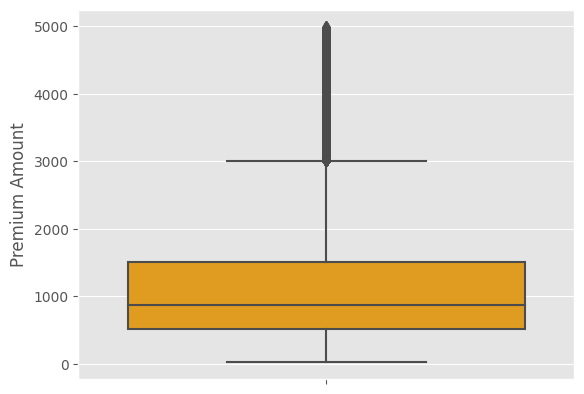

In [16]:
sns.boxplot(data=train, y='Premium Amount', color='orange')

## Splitting the data for model prediction

In [17]:
from sklearn.model_selection import KFold

X = train.copy()
y = X.pop('Premium Amount')
X = add_features(X)
y = np.log(y)

X_test = test.copy()
X_test = add_features(X_test)

kf = KFold(n_splits=10, random_state=340, shuffle=True)
for train_index, valid_index in kf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    

## Using LightGBM for prediction

In [18]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

lgm = LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.012057, 
    min_split_gain= 5.05991, 
    max_depth=11, 
    reg_lambda = 0.70115,  
    random_state=340,
    feature_fraction=0.8,
    n_jobs= -1,
    device_type='gpu',
    verbose=-1
).fit(X_train, y_train)

preds_light = lgm.predict(X_valid)
print(f'RMSLE: {np.sqrt(mean_squared_log_error(preds_light, y_valid)):,.5f}')

RMSLE: 0.16048


## Extracting top features using feature importances

<function matplotlib.pyplot.show(close=None, block=None)>

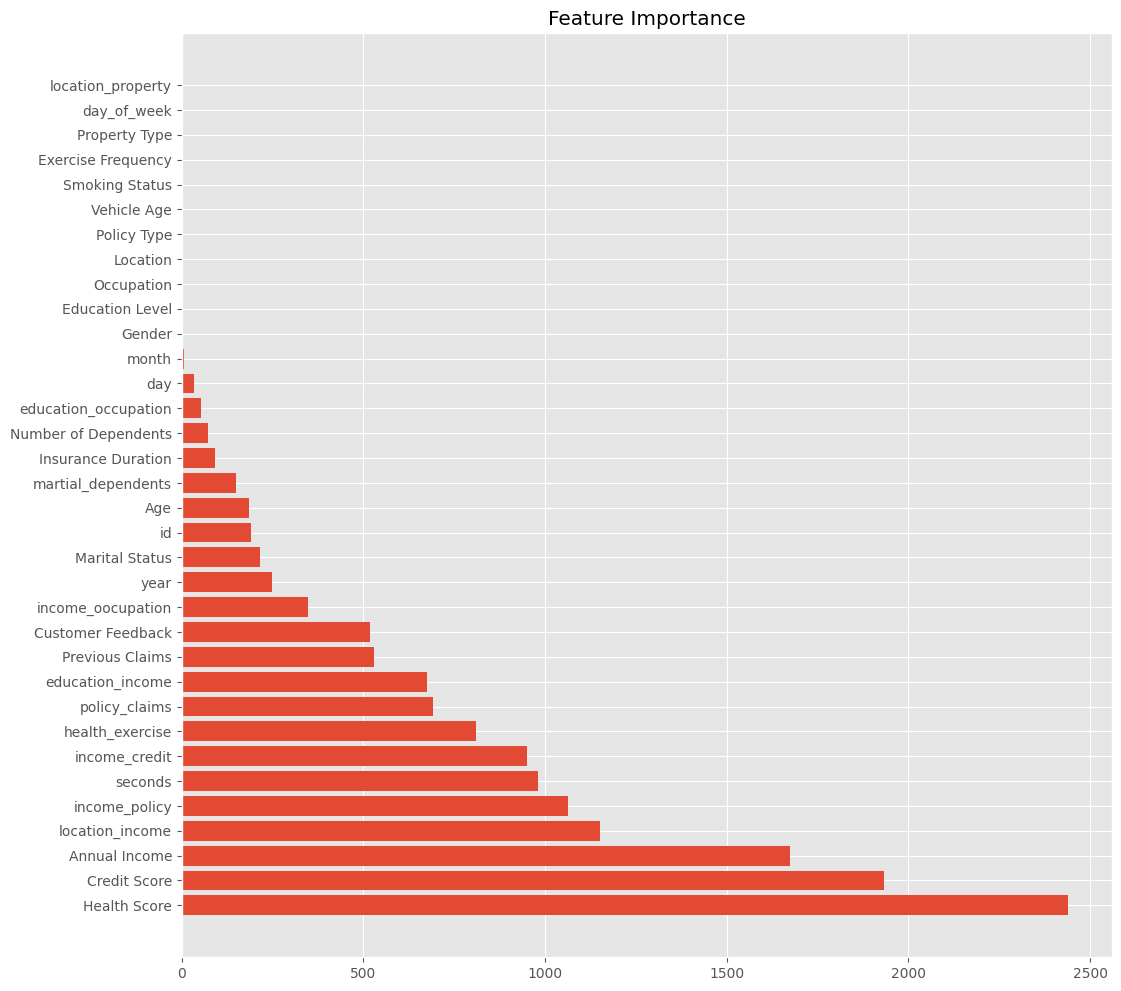

In [19]:
importances = lgm.feature_importances_
columns = X.columns

df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances})
df_importances = df_importances.sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 12))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.title('Feature Importance')
plt.show

In [20]:
threshold = np.quantile(importances, 0.5)
selected_features = columns[importances > threshold]
top_X_train = X_train[selected_features]
print(selected_features)

Index(['id', 'Age', 'Annual Income', 'Marital Status', 'Health Score',
       'Previous Claims', 'Credit Score', 'Customer Feedback', 'year',
       'seconds', 'income_oocupation', 'education_income', 'location_income',
       'income_credit', 'income_policy', 'health_exercise', 'policy_claims'],
      dtype='object')


## Calculating cv score for top feature model

In [21]:
from sklearn.model_selection import cross_val_score

top_model_score = -1 * cross_val_score(lgm, top_X_train, y_train, cv=kf, scoring='neg_mean_squared_log_error').mean()

print(f'{np.sqrt(top_model_score)}')

0.1604596517557221


## Submission

In [22]:
lgm.fit(top_X_train, y_train)
top_X_test = X_test[selected_features]

test_preds = lgm.predict(top_X_test)
sub = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
sub['Premium Amount'] = np.exp(test_preds) - 1
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
sub.head()

Your submission was successfully saved!


,id,Premium Amount
0,1200000,652.575216
1,1200001,792.712599
2,1200002,811.499021
3,1200003,793.664369
4,1200004,764.374297
